# RAPIDS & Scanpy Single-Cell RNA Workflow

This notebook demonstrates an end-to-end single-cell RNA workflow that begins with preprocessing a `(n_gene, n_cell)` count matrix and results in a visualization of the clustered cells for further analysis. 

In [1]:
# Import requirements
import numpy as np
import scanpy as sc
import sys
import os

import cupy as cp

In [2]:
# Please note the csv file in in_file has been modified with the addition of `gene_name` to the very beginning of the csv index.
in_file = "/home/cjnolet/covid_omics_local/Counts_lung_cells.csv"
out_dir = "."

In [3]:
import cudf
import anndata

import time
start = time.time()

## Preprocessing Stage 1
### (load counts -> filter -> normalize)

In [4]:
%%time
# Load data
adata = cudf.read_csv(in_file)

CPU times: user 3.63 s, sys: 1.99 s, total: 5.62 s
Wall time: 5.68 s


In [5]:
adata.columns

Index(['gene_name', 'X101CV0ng_AAACCTGAGGTTCCTA.1',
       'X101CV0ng_AAACCTGCAAGGCTCC.1', 'X101CV0ng_AAACCTGCACGAAATA.1',
       'X101CV0ng_AAACCTGCAGCTATTG.1', 'X101CV0ng_AAACCTGGTGATGCCC.1',
       'X101CV0ng_AAACCTGTCATCATTC.1', 'X101CV0ng_AAACCTGTCCCAGGTG.1',
       'X101CV0ng_AAACGGGAGCTGATAA.1', 'X101CV0ng_AAACGGGCACATTTCT.1',
       ...
       'ZM3KACng_TTTGGTTGTGGGTCAA.1', 'ZM3KACng_TTTGGTTGTTTAGGAA.1',
       'ZM3KACng_TTTGGTTTCCGAATGT.1', 'ZM3KACng_TTTGGTTTCTTGCCGT.1',
       'ZM3KACng_TTTGTCAAGACTCGGA.1', 'ZM3KACng_TTTGTCACAAATACAG.1',
       'ZM3KACng_TTTGTCACAGAGTGTG.1', 'ZM3KACng_TTTGTCACAGTTTACG.1',
       'ZM3KACng_TTTGTCACATCCGCGA.1', 'ZM3KACng_TTTGTCACATGGATGG.1'],
      dtype='object', length=39779)

In [6]:
adata['gene_name'].unique()

0                None
1             5S-rRNA
2                 7SK
3               7SK.1
4               7SK.2
             ...     
32733     hsa-mir-335
32734     hsa-mir-490
32735    hsa-mir-7515
32736    hsa-mir-8072
32737          snoU13
Name: gene_name, Length: 32738, dtype: object

In [7]:
adata.shape

(32738, 39779)

In [8]:
%%time
mito_genes = adata["gene_name"].str.startswith("MT-")
adata = adata.set_index("gene_name")

CPU times: user 354 ms, sys: 10.1 ms, total: 364 ms
Wall time: 363 ms


In [9]:
%%time
gpu_matrix = adata.as_gpu_matrix()

CPU times: user 2.51 s, sys: 142 ms, total: 2.65 s
Wall time: 2.65 s


In [10]:
%%time
import cupy as cp
gpu_array = cp.asarray(gpu_matrix, dtype=cp.float32)

CPU times: user 3.33 ms, sys: 3.09 ms, total: 6.41 ms
Wall time: 5.46 ms


In [11]:
%%time
# Move count matrix to sparse form to ease computational burden.
# Transpose to `(n_cells, n_genes)` in sparse form since it has less computational demands
sparse_gpu_array = cp.sparse.csr_matrix(gpu_array, dtype=cp.float32).T

CPU times: user 532 ms, sys: 349 ms, total: 881 ms
Wall time: 882 ms


In [12]:
sparse_gpu_array.shape

(39778, 32738)

In [13]:
del adata
del gpu_matrix

In [14]:
%%time
# Filter cells w/ 200 <= n_genes <= 6000
# Copying to host (scipy.sparse.csr_matrix) just for filtering. 
# Ref: https://github.com/cupy/cupy/issues/2360
col_sums = sparse_gpu_array.sum(axis=1)
query = ((200 <= col_sums) & (col_sums <= 6000)).ravel()
filtered_cells = sparse_gpu_array.get()[query.get()]

CPU times: user 1.6 s, sys: 1.61 s, total: 3.21 s
Wall time: 3.22 s


In [15]:
%%time
## Filter cells with >15% MT reads
n_counts = filtered_cells.sum(axis=1)
percent_mito = (filtered_cells[:,mito_genes.to_array()].sum(axis=1) / n_counts).ravel()
filtered_cells = filtered_cells[np.asarray(percent_mito < 0.15).ravel(),:]

CPU times: user 393 ms, sys: 143 ms, total: 536 ms
Wall time: 535 ms


In [16]:
%%time
## Remove zero columns
# Copying dense onto GPU for normalization
thr = np.asarray(filtered_cells.sum(axis=0) > 0).ravel()
filtered_cells = filtered_cells[:,thr]
filtered_cells = cp.array(filtered_cells.todense())

CPU times: user 451 ms, sys: 2.21 s, total: 2.66 s
Wall time: 2.69 s


In [17]:
%%time
## Normalize to sum to 1e4 and perform log norm
target_sum = 1e4
sums = cp.array(target_sum / filtered_cells.sum(axis=1)).ravel()
normalized = cp.array(filtered_cells) * sums[:, None]

CPU times: user 364 ms, sys: 278 ms, total: 642 ms
Wall time: 641 ms


In [18]:
%%time
normalized = cp.log1p(normalized)

CPU times: user 12.2 ms, sys: 11.9 ms, total: 24.1 ms
Wall time: 22.9 ms


In [19]:
normalized.shape

(34808, 28192)

## Preprocess Stage 2
### (regress -> scale -> PCA) 

In [20]:
# scanpy uses a Gaussian GLM w/ identity link, which is equivalent to Linear Regression w/  OLS.

In [21]:
n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

In [22]:
regressors = cp.ones((n_counts.shape[0]*3)).reshape((n_counts.shape[0], 3), order="F")

In [23]:
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

In [24]:
df_regressors = cudf.DataFrame.from_gpu_matrix(regressors)

In [25]:
# For each gene, we want to subtract the predicted values from the original values to
# regress out effects of total counts per cell and the percentage expressed of mitochondrial genes 

In [26]:
from cuml.linear_model import LinearRegression

# NOTE: The tens of thousands of little regressions required in this step 
# pose a singificant bottleneck to this workflow.

def _regress_out_chunk(data_chunk, regressors):
    """
    Performs a data_cunk.shape[1] number of local linear regressions,
    replacing the data in the original chunk w/ the regressed result. 
    """
    
    for col in range(data_chunk.shape[1]):
        y = data_chunk[:,col]
        X = regressors
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y, convert_dtype=True)
        mu = lr.predict(X)
        data_chunk[:,col] = data_chunk[:,col] - mu
        
    return data_chunk

In [27]:
%%time
# TODO: This is one bottleneck that can be moved onto GPU
import anndata
adata = anndata.AnnData(normalized.get())

min_disp = 0.5

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=min_disp)
n_genes = sum(adata.var.highly_variable)
adata = adata[:, adata.var.highly_variable]

CPU times: user 8.88 s, sys: 2.68 s, total: 11.6 s
Wall time: 11.6 s


In [28]:
%%time
normalized = cp.array(adata.X)

CPU times: user 1.17 s, sys: 343 ms, total: 1.52 s
Wall time: 1.52 s


In [29]:
%%time
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

import dask.array as da

cluster = LocalCUDACluster()
client = Client(cluster)

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


CPU times: user 416 ms, sys: 593 ms, total: 1.01 s
Wall time: 2.53 s


In [30]:
client

Client Scheduler: tcp://127.0.0.1:45272 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


In [31]:
%%time
normalized = cp.asfortranarray(normalized)

da_normalized = da.from_array(normalized, chunks=(-1, 1000))
da_normalized = da_normalized.map_blocks(lambda cols: _regress_out_chunk(cols, df_regressors), dtype=cp.float32)

CPU times: user 32 ms, sys: 3.99 ms, total: 36 ms
Wall time: 35.3 ms


In [32]:
da_normalized

dask.array<lambda, shape=(34808, 3397), dtype=float32, chunksize=(34808, 1000), chunktype=cupy.ndarray>

In [33]:
%%time
normalized = da_normalized.compute()

CPU times: user 716 ms, sys: 1.4 s, total: 2.12 s
Wall time: 19.4 s


In [34]:
client.close()
cluster.close()

In [35]:
normalized.shape

(34808, 3397)

In [36]:
%%time
# Scale to unit variance and clip values w/ std_dev > 10
mean = normalized.mean(axis=0)
stddev = cp.sqrt(normalized.var(axis=0))
normalized -= mean
normalized /= stddev

CPU times: user 7.4 ms, sys: 4.24 ms, total: 11.6 ms
Wall time: 11.2 ms


In [37]:
%%time
normalized[normalized>10] = 10

CPU times: user 9.89 ms, sys: 9.14 ms, total: 19 ms
Wall time: 18.5 ms


In [38]:
preprocess_time = time.time()

In [39]:
print("Total Preprocess time (includes data load): %s" % (preprocess_time-start))

Total Preprocess time (includes data load): 54.71149134635925


## Cluster & Visualize
### (pca -> cluster -> visualize)

In [40]:
cluster_start = time.time()

In [41]:
%%time
import anndata
adata = anndata.AnnData(normalized.get())

CPU times: user 109 ms, sys: 120 ms, total: 230 ms
Wall time: 228 ms


In [42]:
del normalized

In [43]:
adata.shape

(34808, 3397)

In [44]:
%%time
# PCA
# Note: This is a significant bottleneck but is made better by filtering highly variable genes above.
sc.tl.pca(adata, n_comps=50)

CPU times: user 4min 35s, sys: 1min 16s, total: 5min 51s
Wall time: 12.4 s


In [45]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_pcs=50, method='rapids')

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


CPU times: user 3.81 s, sys: 581 ms, total: 4.4 s
Wall time: 4.38 s


In [46]:
%%time
# UMAP
sc.tl.umap(adata, method='rapids')

AscontiguousArrayTime: 0.0016236305236816406
UMAP TIME: 0.6417760848999023
CPU times: user 360 ms, sys: 287 ms, total: 647 ms
Wall time: 647 ms


In [47]:
%%time
# Louvain clustering
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 124 ms, sys: 40.4 ms, total: 164 ms
Wall time: 170 ms


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cugraph/structure/graph.py:334: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


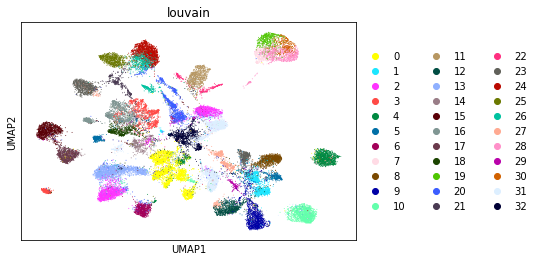

CPU times: user 471 ms, sys: 187 ms, total: 658 ms
Wall time: 457 ms


In [48]:
%%time
# Plot
sc.pl.umap(adata, color='louvain')

In [49]:
print("Cluster time: %s" % (time.time() - cluster_start))

Cluster time: 18.29394030570984


In [50]:
print("Full time: %s" % (time.time() - start))

Full time: 73.0247757434845
